### Point 1 
#### Extend your workflow to incorporate more classes: the CIFAR dataset includes other vehicles that Scones Unlimited can identify with this model.

##### Response:
- 5 types of images (all vehicles) have been used in the dataset : bicycle,  motorcycle,  streetcar,  rocket and  tractor. The validation accuracy is roughly 0.74.
- If I use more, like 9 types of vehicles, I obtain very bad results (validation score of 0.47... the algorithm gives all wrong most of the time). The problem does not come from the algorithm, or from the hyperparameters (for example, learning rate of 0.001). It is just that images are very small (32*32 pixels), so global forms do not distinguish clearly. With more and more types of images, the algorithm gets more and more confused with such small images.


### Point 2   
#### Modify your event driven workflow: can you rewrite your Lambda functions so that the workflow can process multiple image inputs in parallel? Can the Step Function "fan out" to accomodate this new workflow?

##### Response
- An id_image field has been added in the predictLabelImage lambda function. It is then used in the CustomAttributes of the client.invoke_endpoint method. The goal was to pass the real type of vehicle and to compare at a final step the inference and the real type. A matrix confusion was synthetized. It may help to detect drifting datas. May be compared with clarify to detect drifts.
- The map feature of the step function service has been used to take batches.

### Point 3 
#### Consider the test data generator we provided for you. Can we use it to create a "dummy data" generator, to simulate a continuous stream of input data? Or a big paralell load of data?

##### Response
- I used the step function directly from this notebook instead of creating a web app and using api gateway
- A generate_batch function, using the generate_test_case one, has been written.
- The size of the batch varies randomly. 
- The use of the module "schedule" is very handy and it provides an awesome way to simulate a continuous flow of requests, of different sizes with the use of generate_batch function. Yet, We have to stop the kernel manually to interrupt the schedule job.

---
### Imports and requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [270]:
!pip install jsonlines schedule

In [289]:
from uuid import uuid4
import random, json, jsonlines
from time import strftime, sleep
from datetime import datetime as dt, timedelta
import schedule

In [42]:
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()
role = get_execution_role()
region = sess.boto_region_name

import boto3, os

client_s3 = boto3.Session().resource('s3')
client_sagemaker = boto3.client('sagemaker')



In [5]:
sess.default_bucket(), region, role

('sagemaker-us-east-1-416312206633',
 'us-east-1',
 'arn:aws:iam::416312206633:role/service-role/AmazonSageMaker-ExecutionRole-20211216T204468')

In [6]:
working_bucket = 'batch-classification-scones-project'

In [7]:
#!aws s3 rm s3://batch-classification-scones-project --recursive

In [ ]:
#!aws s3 rm s3://batch-classification-scones-project/train_batch_classification --recursive
#!aws s3 rm s3://batch-classification-scones-project/test_batch_classification --recursive
    

In [8]:
#!rm -rf ./train_batch_classification
#!rm -rf ./test_batch_classification

In [9]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [12]:
pd.DataFrame(dataset_train[b'fine_labels'])

,0
0,19
1,29
2,0
3,11
4,1
...,...
49995,80
49996,7
49997,3
49998,7


In [13]:
pd_fine_labels = pd.DataFrame(dataset_train[b'fine_labels'])
pd.crosstab(index=pd_fine_labels[0], columns="count")

col_0,count
0,
0,500
1,500
2,500
3,500
4,500
...,...
95,500
96,500
97,500


In [14]:
pd_fine_labels.value_counts()

99    500
36    500
26    500
27    500
28    500
     ... 
69    500
70    500
71    500
72    500
0     500
Length: 100, dtype: int64

In [15]:
#print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])
pd.DataFrame(dataset_train[b'fine_labels'])

,0
0,19
1,29
2,0
3,11
4,1
...,...
49995,80
49996,7
49997,3
49998,7


In [16]:
dataset_meta[b'fine_label_names']

[b'apple',
 b'aquarium_fish',
 b'baby',
 b'bear',
 b'beaver',
 b'bed',
 b'bee',
 b'beetle',
 b'bicycle',
 b'bottle',
 b'bowl',
 b'boy',
 b'bridge',
 b'bus',
 b'butterfly',
 b'camel',
 b'can',
 b'castle',
 b'caterpillar',
 b'cattle',
 b'chair',
 b'chimpanzee',
 b'clock',
 b'cloud',
 b'cockroach',
 b'couch',
 b'crab',
 b'crocodile',
 b'cup',
 b'dinosaur',
 b'dolphin',
 b'elephant',
 b'flatfish',
 b'forest',
 b'fox',
 b'girl',
 b'hamster',
 b'house',
 b'kangaroo',
 b'keyboard',
 b'lamp',
 b'lawn_mower',
 b'leopard',
 b'lion',
 b'lizard',
 b'lobster',
 b'man',
 b'maple_tree',
 b'motorcycle',
 b'mountain',
 b'mouse',
 b'mushroom',
 b'oak_tree',
 b'orange',
 b'orchid',
 b'otter',
 b'palm_tree',
 b'pear',
 b'pickup_truck',
 b'pine_tree',
 b'plain',
 b'plate',
 b'poppy',
 b'porcupine',
 b'possum',
 b'rabbit',
 b'raccoon',
 b'ray',
 b'road',
 b'rocket',
 b'rose',
 b'sea',
 b'seal',
 b'shark',
 b'shrew',
 b'skunk',
 b'skyscraper',
 b'snail',
 b'snake',
 b'spider',
 b'squirrel',
 b'streetcar',
 b

In [17]:
#types_vehicles = [b'bus', b'bicycle', b'pickup_truck', b'rocket', b'motorcycle', b'streetcar', b'tank', b'tractor', b'train']
types_vehicles = [b'bicycle', b'motorcycle',  b'streetcar', b'rocket', b'tractor']

In [18]:
# RECOVER NUMBER VEHICLES FROM THE LITTERAL NAMES CHOSEN ABOVE

# liste 1 : dataset_meta[b'fine_label_names']
# liste 2 : type_vehicles

# Indices list of matching element from other list
# Using list comprehension + set() + enumerate()
temp_vehicles = set(types_vehicles)
numbers_type_vehicle = [i for i, val in enumerate(dataset_meta[b'fine_label_names']) if val in temp_vehicles]
numbers_type_vehicle

[8, 48, 69, 81, 89]

In [19]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not in types_vehicles
df_train = df_train[df_train['labels'].isin(numbers_type_vehicle)]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not in types_vehicles
df_test = df_test[df_test['labels'].isin(numbers_type_vehicle)]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

In [20]:
df_train["filenames"].shape

(2500,)

In [21]:
df_test["filenames"].shape

(500,)

In [22]:
df_train.head(15)

,filenames,labels,row
16,bike_s_000682.png,8,16
30,bike_s_000127.png,8,30
36,streetcar_s_000663.png,81,36
48,tractor_s_001723.png,89,48
73,tractor_s_000104.png,89,73
76,bulldozer_s_000433.png,89,76
93,minuteman_s_000073.png,69,93
107,icbm_s_000392.png,69,107
130,cycle_s_002598.png,8,130
152,minibike_s_000824.png,48,152


In [18]:
df_test.head(15)

,filenames,labels,row
12,streetcar_s_000382.png,81,12
13,sounding_rocket_s_000010.png,69,13
27,safety_bike_s_000390.png,8,27
28,bike_s_000658.png,8,28
59,exocet_s_000376.png,69,59
85,dozer_s_001228.png,89,85
105,research_rocket_s_001220.png,69,105
116,velocipede_s_001744.png,8,116
161,bike_s_000643.png,8,161
219,streetcar_s_000124.png,81,219


In [19]:
# To uncomment if needed

#!mkdir -p ./train_batch_classification/images
#!mkdir -p ./test_batch_classification/images

In [22]:
def save_images(idx_image, channel, dataset):
    #Grab the image data in row-major form
    img = dataset[b'data'][idx_image]
    
    # Consolidated stacking/reshaping from earlier
    target = np.dstack((
            img[:1024].reshape(32, 32),
            img[1024:2048].reshape(32, 32),
            img[2048:].reshape(32, 32)
    ))
    
    # Save the image
    plt.imsave(f"./{channel}/images/{dataset[b'filenames'][idx_image].decode('utf-8')}", target)
    
    # Return any signal data you want for debugging
    return

for idx in df_train.index.values:
    save_images(idx, 'train_batch_classification', dataset_train)
    
for idx in df_test.index.values:
    save_images(idx, 'test_batch_classification', dataset_test)

In [24]:
#To uncomment if needed

#os.environ["WORKING_BUCKET"] = working_bucket
#!aws s3 sync ./train_batch_classification s3://${WORKING_BUCKET}/train_batch_classification/
#!aws s3 sync ./test_batch_classification s3://${WORKING_BUCKET}/test_batch_classification/

In [23]:
numbers_type_vehicle

[8, 48, 69, 81, 89]

In [24]:
types_vehicles

[b'bicycle', b'motorcycle', b'streetcar', b'rocket', b'tractor']

In [25]:
#have not been really useful...
types_vehicles = list(zip(numbers_type_vehicle, types_vehicles))
[type for type in types_vehicles]

[(8, b'bicycle'),
 (48, b'motorcycle'),
 (69, b'streetcar'),
 (81, b'rocket'),
 (89, b'tractor')]

In [26]:
litteral_type_vehicles= [type_vehicle[1].decode('utf-8') for type_vehicle in types_vehicles]
litteral_type_vehicles

['bicycle', 'motorcycle', 'streetcar', 'rocket', 'tractor']

In [27]:
types_vehicles[-1]

(89, b'tractor')

In [29]:
df_test["labels"]

12      81
13      69
27       8
28       8
59      69
        ..
9922    89
9928     8
9939     8
9946    69
9969    89
Name: labels, Length: 500, dtype: int64

--- 
### Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [33]:
numbers_type_vehicle

[8, 48, 69, 81, 89]

In [34]:
# Get the index in the array ( 0, 1, 2, 3 or 4) instead of (8, 48, 69, 81, 89), for example
# -> used by the lst file to simplify the labels sequences

def return_index_vehicle(number_vehicle):
    index_vehicle = 0
    while number_vehicle != numbers_type_vehicle[index_vehicle]:
        index_vehicle += 1
    return index_vehicle

In [36]:
return_index_vehicle(48)

1

In [35]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: return_index_vehicle(x))
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train_batch_classification")
to_metadata_file(df_test.copy(), "test_batch_classification")

In [36]:
# Upload .lst files
client_s3.Bucket(working_bucket).Object('train_batch_classification.lst').upload_file('./train_batch_classification.lst')
client_s3.Bucket(working_bucket).Object('test_batch_classification.lst').upload_file('./test_batch_classification.lst')

In [37]:
from sagemaker import image_uris

# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = image_uris.retrieve(framework='image-classification', region=region)
s3_output_location = f"s3://{working_bucket}/models/image_model"

In [38]:
s3_output_location

's3://batch-classification-scones-project/models/image_model'

In [39]:
#TESTED WITH SPOT INSTANCES, BUT HAD SOME TROUBLE WITH HYPERPARAMETERS THAT WERE NOT MATCHING. I DID NOT NOT INVESTIGATE FURTHERMORE.

# The local path where the model will save its checkpoints in the training container
checkpoint_local_path="/opt/ml/checkpoints" 

# The S3 URI to store the checkpoints
checkpoint_s3_bucket=f"s3://{working_bucket}/checkpoints"

#### Choice of parameters

In [41]:
#parameters for spot instance
use_spot_instances = True # Not simple to have spot capacity. Have to try many times. Perhaps I would try in another region, but all would have to be moved (s3...) 
max_run = 3600
max_wait = 7200 if use_spot_instances else None

In [42]:
#supported instances for image classification prebuilt sagemaker algorithms
# 'ml.p2.xlarge', 'ml.p2.8xlarge', 'ml.p2.16xlarge', 'ml.p3.2xlarge', 'ml.p3.8xlargeand', 'ml.p3.16xlarge'
instance_training_type = 'ml.p3.2xlarge'

In [ ]:
#model_uuid = uuid4()

In [43]:

img_classifier_model=sagemaker.estimator.Estimator(
    ## TODO: define your estimator options  
    algo_image,
    role,
    instance_count= 1,
    instance_type= instance_training_type,
    use_spot_instances= use_spot_instances,
    max_run= max_run,
    max_wait = max_wait,    
    output_path= s3_output_location,
    #name=
    #checkpoint_s3_uri=checkpoint_s3_bucket,    
    #checkpoint_local_path=checkpoint_local_path   
)

In [44]:
len(numbers_type_vehicle)

5

In [466]:
#img_classifier_model.set_hyperparameters(
#    image_shape= '3,32,32', # TODO: Fill in
#    num_classes=2, # TODO: Fill in
#    num_training_samples=1000, # TODO: fill in
#    learning_rate=0.05
#)

In [45]:
num_training_samples=2500  ###        TO ADAPT !!!       NOT TO FORGET  !!!!

In [46]:
# hyperparameters for training
img_classifier_model.set_hyperparameters(
    image_shape= '3,32,32', # TODO: Fill in
    num_classes= len(numbers_type_vehicle), # TODO: Fill in
    num_training_samples= num_training_samples, # TODO: fill in
    learning_rate=0.01, 
    mini_batch_size= 64,
    epochs=50
)

#{'num_classes': '3', 'num_training_samples': '1500', 'image_shape': '3,32,32', 'learning_rate': '0.01'}

In [47]:
train_input = f"s3://{working_bucket}/train_batch_classification/images/"
test_input  = f"s3://{working_bucket}/test_batch_classification/images/"
train_lst  = f"s3://{working_bucket}/train_batch_classification.lst"
test_lst  = f"s3://{working_bucket}/test_batch_classification.lst"

In [48]:
print(train_input)
print(test_input)
print(train_lst)
print(test_lst)

s3://batch-classification-scones-project/train_batch_classification/images/
s3://batch-classification-scones-project/test_batch_classification/images/
s3://batch-classification-scones-project/train_batch_classification.lst
s3://batch-classification-scones-project/test_batch_classification.lst


In [49]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=train_input,
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=test_input,
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=train_lst,
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=test_lst,
            content_type="application/x-image"
        )
}

In [50]:
img_classifier_model.fit(model_inputs)

2022-01-30 18:42:17 Starting - Starting the training job...
2022-01-30 18:42:47 Starting - Launching requested ML instancesProfilerReport-1643568137: InProgress
......
2022-01-30 18:43:47 Starting - Preparing the instances for training........
2022-01-30 18:45:07 Downloading - Downloading input data...
2022-01-30 18:45:47 Training - Downloading the training image......
2022-01-30 18:46:48 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[01/30/2022 18:46:40 INFO 140223575467840] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[01/30/2022 18:46:40 I

--- 

### Deployment



In [38]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture= True,
    sampling_percentage= 100,
    destination_s3_uri= f"s3://{working_bucket}/data_capture",
)

In [193]:
#f'batch_classification-TIME-{dt.now().strftime("%Y-%m-%d-%H-%M-%S-%f")}-ID-{str(uuid4())}'

##### Two choices for creating an endpoint : 
- first time creation : next cell
- endpoint configuration already created : let's take profit of it ---> second cell below
---

##### Not both ! 

In [192]:
deployment = img_classifier_model.deploy(
    data_capture_config=data_capture_config,
    initial_instance_count= 1, 
    instance_type= 'ml.t2.medium', 
    endpoint_name= f'batch-classification-TIME-{dt.now().strftime("%Y-%m-%d-%H-%M-%S-%f")}'
    )

endpoint_name = deployment.endpoint_name
print(endpoint_name)

--------------------------!batch-classification-TIME-2022-01-31-00-39-16-098164


##### Alternatively, if configuration endpoint has already been created before, do the following instead of cell above
##### Just to change name of configuration config already created

In [43]:
endpoint_config_name='batch-classification-TIME-2022-01-31-00-39-16-098164'
endpoint_name = 'ENDPOINT-' + endpoint_config_name
create_endpoint_response = client_sagemaker.create_endpoint(
                                    EndpointName=endpoint_name, 
                                    EndpointConfigName=endpoint_config_name) 
create_endpoint_response

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:416312206633:endpoint/endpoint-batch-classification-time-2022-01-31-00-39-16-098164',
 'ResponseMetadata': {'RequestId': 'b583c049-083c-44d7-b79c-4686e7ed0b0a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b583c049-083c-44d7-b79c-4686e7ed0b0a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '129',
   'date': 'Mon, 31 Jan 2022 13:15:13 GMT'},
  'RetryAttempts': 0}}

--- 
#### Predictions

##### _Predictions and analyses_

In [46]:
from sagemaker.predictor import Predictor

predictor = Predictor(endpoint_name)

In [47]:
from sagemaker.serializers import IdentitySerializer

predictor.serializer = IdentitySerializer("image/png")
with open("./test_batch_classification/images/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

inference = predictor.predict(payload)

In [48]:
print(inference)

b'[0.9782111048698425, 0.013572802767157555, 0.006240911316126585, 0.00013658084208145738, 0.0018385974690318108]'


In [49]:
litteral_types_vehicles= [type_vehicle[1].decode('utf-8') for type_vehicle in types_vehicles]

--- 
#### Data capture

In [37]:
f"s3://{working_bucket}/data_capture"

's3://batch-classification-scones-project/data_capture'

##### _Sanitizing local and distant folders for data capture._
##### _With precaution, if needed..._

In [50]:
#TO SANITIZE DATA CAPTURE FOLDER LOCALLY

local_path_of_data_capture = './batch_classification/captured_data'

In [ ]:
#os.environ["local_path_of_data_capture"] = local_path_of_data_capture
#!echo ${local_path_of_data_capture}

In [ ]:
#!rm -rf local_path_of_data_capture

In [331]:
#TO SANITIZE DATA CAPTURE FOLDER IN S3, NOT LOCALLY!

s3_path_to_sanitize = f's3://{working_bucket}/data_capture/{endpoint_name}/AllTraffic/'
# Or s3_path_to_sanitize = f's3://{working_bucket}/data_capture/' # to sanitize everything

In [187]:
#os.environ["s3_path_to_sanitize"] = s3_path_to_sanitize
#!echo ${s3_path_to_sanitize}

://batch-classification-scones-project/data_capture/batch-classification-TIME-2022-01-30-19-36-14-465184/AllTraffic/


In [ ]:
#!aws s3 rm ${folder_to_sanitize} --recursive

##### _Downloading from S3 to local folder._

In [53]:
from sagemaker.s3 import S3Downloader

# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_capture_path = f"s3://{working_bucket}/data_capture/"    #Take all previous predictions if not all folders are sanitized

S3Downloader.download(data_capture_path, local_path_of_data_capture)



In [54]:
data_capture_path

's3://batch-classification-scones-project/data_capture/'

In [55]:
file_handles = os.listdir(local_path_of_data_capture)
print(file_handles)

['batch-classification-TIME-2022-01-30-19-36-14-465184', 'batch-classification-TIME-2022-01-31-00-39-16-098164']


In [56]:
json_data = []
# List the file names we downloaded
for root, dirs, files in os.walk(local_path_of_data_capture, topdown=False):
    for name in files:
        with jsonlines.open(os.path.join(root, name)) as f:
            for line in f:
                json_data.append(line)    # To take all lines as many jsonlines can exist in a single file !!
         #       print(line)
        #print("###############" + os.path.join(root, name))

In [58]:
len(json_data)

160

In [59]:
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    #print(obj["eventMetadata"])
    id = int(obj["eventMetadata"]["customAttributes"][0] )
    return json.loads(inferences), timestamp, id

#range(len(json_data))
#list_max_inferences = [max(simple_getter(json_data[idx])[0]) for idx in range(len(json_data))]
#probabilities= [simple_getter(json_data[idx])[0],  for idx in range(len(json_data))]
results = []
for element in json_data:
    simple_getter(element)
    inferences, _, id = simple_getter(element)
    max_inferences = round(max(inferences), 2)
    #print(f"MAX  : {max_inferences}")
    results.append([inferences, max_inferences, id])

temp = pd.DataFrame(results, columns=["probs", "max", "id"])
df_results = pd.DataFrame(temp['probs'].to_list()).round(2)
df_results.columns= litteral_types_vehicles
df_results = pd.concat([df_results, temp['max'], temp['id']], axis=1)

df_results


,bicycle,motorcycle,streetcar,rocket,tractor,max,id
0,0.00,1.00,0.00,0.00,0.00,1.00,1464
1,0.22,0.08,0.00,0.27,0.43,0.43,1408
2,0.00,0.35,0.00,0.20,0.45,0.45,1463
3,0.00,1.00,0.00,0.00,0.00,1.00,1404
4,0.00,0.99,0.00,0.01,0.00,0.99,1398
...,...,...,...,...,...,...,...
155,0.94,0.05,0.01,0.00,0.00,0.94,2082
156,0.00,0.00,0.00,0.00,1.00,1.00,2101
157,0.00,0.00,0.00,0.00,1.00,1.00,2123
158,0.00,0.00,0.00,1.00,0.00,1.00,2121


In [ ]:
### DRAFT  ###
'''
pd.DataFrame({"results": results, "id": })
df_results= pd.DataFrame(pd.DataFrame("results": results).to_list())

df_results = df_results.round(2)
#df_probabilities_result = pd.DataFrame(probabilities)
#df_probabilities_result.round(2).describe()
#list_max_inferences
#df_probabilities_result.columns= litteral_types_vehicles
df_results
'''

In [62]:
#list_max_inferences[8]
#probabilities[8]

In [95]:
df_results['id'].dtype, df_pool_vehicles_to_test['id_vehicle'].dtype

(dtype('int64'), dtype('int64'))

In [87]:
df_pool_vehicles_to_test = pd.read_csv("./test_batch_classification.lst", sep="\t", header=None)
df_pool_vehicles_to_test.columns=['id_vehicle', 'number_type_vehicle', 'filename']
df_pool_vehicles_to_test

,id_vehicle,number_type_vehicle,filename
0,12,3,streetcar_s_000382.png
1,13,2,sounding_rocket_s_000010.png
2,27,0,safety_bike_s_000390.png
3,28,0,bike_s_000658.png
4,59,2,exocet_s_000376.png
...,...,...,...
495,9922,4,bulldozer_s_000636.png
496,9928,0,ordinary_bicycle_s_000105.png
497,9939,0,bicycle_s_001218.png
498,9946,2,ballistic_missile_s_001240.png


In [88]:
df_pool_vehicles_to_test['id_vehicle']

0        12
1        13
2        27
3        28
4        59
       ... 
495    9922
496    9928
497    9939
498    9946
499    9969
Name: id_vehicle, Length: 500, dtype: int64

In [98]:
df_pool_vehicles_to_test['id_vehicle'].isin(df_results['id']).value_counts()

False    460
True      40
Name: id_vehicle, dtype: int64

In [104]:
df_pool_vehicles_to_test[df_pool_vehicles_to_test['id_vehicle'].isin(df_results['id'])].head()

,id_vehicle,number_type_vehicle,filename
72,1398,0,cycle_s_001297.png
73,1404,1,motorcycle_s_001955.png
74,1408,0,cycle_s_001953.png
75,1463,1,motorcycle_s_000494.png
76,1464,1,motorcycle_s_001249.png


In [106]:
df_pool_vehicles_to_test['id_vehicle'].isin(df_results['id']).value_counts()

False    460
True      40
Name: id_vehicle, dtype: int64

,id_vehicle,number_type_vehicle,filename
72,1398,0,cycle_s_001297.png
73,1404,1,motorcycle_s_001955.png
74,1408,0,cycle_s_001953.png
75,1463,1,motorcycle_s_000494.png
76,1464,1,motorcycle_s_001249.png
77,1469,0,velocipede_s_000292.png
78,1522,2,research_rocket_s_000011.png
79,1534,2,rocket_s_000056.png
80,1545,3,streetcar_s_001754.png
81,1554,2,guided_missile_s_000378.png


In [119]:
vehicle_row=df_pool_vehicles_to_test[df_pool_vehicles_to_test['id_vehicle']==1464]
vehicle_row

,id_vehicle,number_type_vehicle,filename
76,1464,1,motorcycle_s_001249.png


In [146]:
#df_results['id'].apply(lambda x: x.Fee in [20000,22000], axis=1)
def get_real_number_type_vehicle(x):
    vehicle_row=df_pool_vehicles_to_test[df_pool_vehicles_to_test['id_vehicle']==x]
    #print(vehicle_row)
    return int(vehicle_row['number_type_vehicle'])

#df_results['id'].apply(lambda x : x )
print(get_real_number_type_vehicle(2121))

3


In [152]:
df_results['real type number']=df_results['id'].apply(lambda x : get_real_number_type_vehicle(x) )
df_results['real type name']=df_results['real type number'].apply(lambda x: litteral_types_vehicles[x])
df_results

,bicycle,motorcycle,streetcar,rocket,tractor,max,id,real type,real type name,real type number
0,0.00,1.00,0.00,0.00,0.00,1.00,1464,1,motorcycle,1
1,0.22,0.08,0.00,0.27,0.43,0.43,1408,0,bicycle,0
2,0.00,0.35,0.00,0.20,0.45,0.45,1463,1,motorcycle,1
3,0.00,1.00,0.00,0.00,0.00,1.00,1404,1,motorcycle,1
4,0.00,0.99,0.00,0.01,0.00,0.99,1398,0,bicycle,0
...,...,...,...,...,...,...,...,...,...,...
155,0.94,0.05,0.01,0.00,0.00,0.94,2082,1,motorcycle,1
156,0.00,0.00,0.00,0.00,1.00,1.00,2101,4,tractor,4
157,0.00,0.00,0.00,0.00,1.00,1.00,2123,4,tractor,4
158,0.00,0.00,0.00,1.00,0.00,1.00,2121,3,rocket,3


In [158]:
df_results

,bicycle,motorcycle,streetcar,rocket,tractor,max,id,real type name,real type number
0,0.00,1.00,0.00,0.00,0.00,1.00,1464,motorcycle,1
1,0.22,0.08,0.00,0.27,0.43,0.43,1408,bicycle,0
2,0.00,0.35,0.00,0.20,0.45,0.45,1463,motorcycle,1
3,0.00,1.00,0.00,0.00,0.00,1.00,1404,motorcycle,1
4,0.00,0.99,0.00,0.01,0.00,0.99,1398,bicycle,0
...,...,...,...,...,...,...,...,...,...
155,0.94,0.05,0.01,0.00,0.00,0.94,2082,motorcycle,1
156,0.00,0.00,0.00,0.00,1.00,1.00,2101,tractor,4
157,0.00,0.00,0.00,0.00,1.00,1.00,2123,tractor,4
158,0.00,0.00,0.00,1.00,0.00,1.00,2121,rocket,3


In [181]:
df_results['infered type']=df_results[litteral_types_vehicles].idxmax(axis=1)
df_results['comparison']= (df_results['real type name']==df_results['infered type'])

df_results

,bicycle,motorcycle,streetcar,rocket,tractor,max,id,real type name,real type number,infered type,comparison
0,0.00,1.00,0.00,0.00,0.00,1.00,1464,motorcycle,1,motorcycle,True
1,0.22,0.08,0.00,0.27,0.43,0.43,1408,bicycle,0,tractor,False
2,0.00,0.35,0.00,0.20,0.45,0.45,1463,motorcycle,1,tractor,False
3,0.00,1.00,0.00,0.00,0.00,1.00,1404,motorcycle,1,motorcycle,True
4,0.00,0.99,0.00,0.01,0.00,0.99,1398,bicycle,0,motorcycle,False
...,...,...,...,...,...,...,...,...,...,...,...
155,0.94,0.05,0.01,0.00,0.00,0.94,2082,motorcycle,1,bicycle,False
156,0.00,0.00,0.00,0.00,1.00,1.00,2101,tractor,4,tractor,True
157,0.00,0.00,0.00,0.00,1.00,1.00,2123,tractor,4,tractor,True
158,0.00,0.00,0.00,1.00,0.00,1.00,2121,rocket,3,rocket,True


In [182]:
df_results.value_counts()

bicycle  motorcycle  streetcar  rocket  tractor  max   id    real type name  real type number  infered type  comparison
1.00     0.00        0.00       0.00    0.00     1.00  1999  bicycle         0                 bicycle       True          4
                                                       1675  bicycle         0                 bicycle       True          4
0.00     0.04        0.00       0.90    0.06     0.90  1900  rocket          3                 rocket        True          4
         0.00        1.00       0.00    0.00     1.00  1935  streetcar       2                 streetcar     True          4
                                                       1931  streetcar       2                 streetcar     True          4
                                                       1745  streetcar       2                 streetcar     True          4
                                                       1735  streetcar       2                 streetcar     True          4
     

In [183]:
df_results['comparison'].value_counts()

True     108
False     52
Name: comparison, dtype: int64

In [188]:
#pd.crosstab(index=df_results['comparison'].value_counts(), columns="proportions", normalize='index')

In [332]:
accuracy = 108/(52+108)
accuracy

0.675

Not so great... 

##### Confusion matrix 

In [334]:
confusion_matrix = pd.crosstab(df_results['real type name'], df_results['infered type'], rownames= ['Actual'], colnames= ['Predicted'])
confusion_matrix

Predicted,bicycle,motorcycle,rocket,streetcar,tractor
Actual,,,,,
bicycle,16,4,0,0,4
motorcycle,4,24,0,0,12
rocket,0,0,16,0,8
streetcar,0,0,8,32,0
tractor,8,4,0,0,20


As we can see, some very specific associations appear : 
- motorcycle, bicycle and tractors are often confused between themselves
- rocket can be predicted as tractor 
- streetcar can be predicted as as rocket

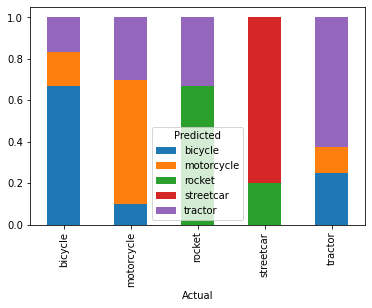

In [194]:
#pd.crosstab(df.Region, df.Type, normalize='index').plot.bar(stacked=True)
pd.crosstab(df_results['real type name'], df_results['infered type'], rownames= ['Actual'], colnames= ['Predicted'], normalize='index') \
  .plot.bar(stacked=True);
#pd.crosstab(df.Region, df.Type, normalize='index').plot.bar(stacked=True)
#confusion_matrix.plot.bar(stacked=True)

In [195]:
#df_results['id'].isin(pool_vehicles_to_test)

In [179]:
litteral_types_vehicles

['bicycle', 'motorcycle', 'streetcar', 'rocket', 'tractor']

In [212]:
string = "test_batch_classification/images/tractor_s_000657.png"
string.split('/')[-1]


'tractor_s_000657.png'

In [239]:
id_image=int(df_test[df_test['filenames']=='tractor_s_000657.png']['row'])
str(id_image)

'1181'

In [245]:
def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(working_bucket).objects.filter(Prefix="test")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    filename= obj.split('/')[-1]
    id_image= int(df_test[df_test['filenames']==filename]['row'])
    #id_image=df_test[df_test['filenames']==obj]['row']
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": working_bucket,
        "s3_key": obj, 
        "id_image": str(id_image)
    })
generate_test_case()


'{"image_data": "", "s3_bucket": "batch-classification-scones-project", "s3_key": "test_batch_classification/images/trail_bike_s_000073.png", "id_image": "9654"}'

In [246]:
step_function_client = boto3.client('stepfunctions')

In [247]:
array_images = []

In [248]:
test_case = generate_test_case()
array_images.append(test_case)

In [325]:
state_machine_arn = 'arn:aws:states:us-east-1:416312206633:stateMachine:VehiculePredictor-Batch-Workflow'

def generate_batch(max_batch_length=10):
    array_images = []
    batch_length= random.randrange(1,max_batch_length)
    print(f"length of batch generated: {batch_length}")
    for i in range(batch_length):
        test_case = generate_test_case()
        array_images.append(test_case)
    
    input= json.dumps({
                "images": array_images
                })
    #print(input)
    
    response = step_function_client.start_execution(
        stateMachineArn=state_machine_arn,
        name=f'execution-from-notebook-TIME-{dt.now().strftime("%Y-%m-%d-%H-%M-%S-%f")}',
        input= input
        )
    
    #print(input)
    return response

#generate_batch()

In [326]:
schedule \
    .every(5) \
    .to(10)  \
    .seconds  \
    .until(timedelta(seconds=45))  \
    .do(generate_batch, 5)  \
    .tag('step-function-scheduling')
#schedule.every(1).hours.until(timedelta(hours=8)).do(job)
#schedule.every(5).to(10).seconds.do(my_job)


Every 5 to 10 seconds do generate_batch(5) (last run: [never], next run: 2022-01-31 18:41:48)

In [327]:
#schedule.every(5).seconds.do(generate_batch)

In [328]:
while True:
    schedule.run_pending()
    sleep(1)
    

4
3
3
2
2
1
4


KeyboardInterrupt: 

In [329]:
all_jobs = schedule.get_jobs()
all_jobs

[]

In [310]:
schedule.clear('step-function-scheduling')